In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Collect exoplanets from the NASA Exoplanet Archive

In [3]:
# calculate mean value, along with its uncertainty, removing nans and values without reported uncertainties
def get_mean_unc(vals, uncs):
    mean_uncs = 0.5*(np.array(uncs)[:,0] - np.array(uncs)[:,1])
    mask = np.logical_not((np.isnan(mean_uncs) | np.isnan(vals) | np.equal(mean_uncs, 0.00)))
    xs = np.array(vals)[mask]
    sigmas = mean_uncs[mask]
    
    if len(xs) > 0 and np.sum(sigmas) != 0.0:
        weights = 1/(sigmas**2)
        mean = np.sum(xs*weights)/np.sum(weights)
        unc = 1/np.sqrt(np.sum(weights))
        
        return mean, unc
    
    return np.nan, np.nan

In [4]:
# convenience function: collect all values and uncertainties for the quantity at index 'ind' in 'planets_arr'
def collect_vals_uncs(planets_arr, ind):
    vals, uncs = [], []
    for i in range(len(planets_arr)):
        vals.append(planets_arr[i][ind])
        uncs.append([planets_arr[i][ind+1], planets_arr[i][ind+2]])
    
    return np.array(vals), np.array(uncs)

In [5]:
# convenience function: collect all values for a particular planet
def collect_systems(uniq_planet_names, final_props, final_prop_uncs):
    sys_names = []
    sys_props = []
    sys_prop_uncs = []
    for i in range(len(uniq_planet_names)):
        sys_name = uniq_planet_names[i][:-2]
        if not sys_name in sys_names:
            temp_props = []
            temp_prop_uncs = []
            for j in range(len(uniq_planet_names)):
                if uniq_planet_names[j][:-2] == sys_name:
                    temp_props.append(final_props[j])
                    temp_prop_uncs.append(final_prop_uncs[j])

            sys_names.append(sys_name)
            sys_props.append(temp_props)
            sys_prop_uncs.append(temp_prop_uncs)
            
    return np.array(sys_names), sys_props, sys_prop_uncs

In [6]:
# convenience function: collect values for all planets discovered using a specific detection technique
# combines multiple reported values by calculating the mean and its uncertainty
def calc_mean_unc(planet_names, vals, uncs, discovery_methods, desired_method):
    uniq_planet_names = []
    means, mean_uncs = [], []
    for i in range(len(planet_names)):
        if discovery_methods[i] == desired_method:
            if not planet_names[i] in uniq_planet_names:
                uniq_planet_names.append(planet_names[i])
                inds = np.where(planet_names == planet_names[i])[0]

                if len(inds) > 1:
                    mean, mean_unc = get_mean_unc(vals[inds], uncs[inds])
                    means.append(mean)
                    mean_uncs.append(mean_unc)
                else:
                    means.append(vals[i])
                    mean_uncs.append(0.5*(uncs[i][0] - uncs[i][1]))
                
    return np.array(uniq_planet_names), np.array(means), np.array(mean_uncs)

In [7]:
# load all confirmed planets as of July 27th, 2025
planets_table = pd.read_csv('data/exoplanet_archive_confirmed_07_2025.csv', skiprows=96)
planets_arr = np.array(planets_table)
planets_table

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2023-09-19,2023-08,2023-09-19
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
2,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
3,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38629,ups And d,ups And,0,2,3,Radial Velocity,1999,Multiple Observatories,Published Confirmed,0,...,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937,2014-09-18,2007-01,2014-09-18
38630,ups Leo b,ups Leo,1,1,1,Radial Velocity,2021,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.184,0.248,-0.248,4.03040,0.008513,-0.008513,2022-01-10,2021-12,2022-01-10
38631,xi Aql b,xi Aql,0,1,1,Radial Velocity,2007,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.171,0.220,-0.220,4.42501,0.003837,-0.003837,2014-07-23,2011-08,2014-07-23
38632,xi Aql b,xi Aql,0,1,1,Radial Velocity,2007,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.171,0.220,-0.220,4.42501,0.003837,-0.003837,2014-05-14,2008-06,2014-05-14


In [8]:
# quantities in exoplanet archive table
for i in range(len(planets_table.columns)):
    print(i, planets_table.columns[i])

0 pl_name
1 hostname
2 default_flag
3 sy_snum
4 sy_pnum
5 discoverymethod
6 disc_year
7 disc_facility
8 soltype
9 pl_controv_flag
10 pl_refname
11 pl_orbper
12 pl_orbpererr1
13 pl_orbpererr2
14 pl_orbperlim
15 pl_orbsmax
16 pl_orbsmaxerr1
17 pl_orbsmaxerr2
18 pl_orbsmaxlim
19 pl_rade
20 pl_radeerr1
21 pl_radeerr2
22 pl_radelim
23 pl_radj
24 pl_radjerr1
25 pl_radjerr2
26 pl_radjlim
27 pl_bmasse
28 pl_bmasseerr1
29 pl_bmasseerr2
30 pl_bmasselim
31 pl_bmassj
32 pl_bmassjerr1
33 pl_bmassjerr2
34 pl_bmassjlim
35 pl_bmassprov
36 pl_orbeccen
37 pl_orbeccenerr1
38 pl_orbeccenerr2
39 pl_orbeccenlim
40 pl_insol
41 pl_insolerr1
42 pl_insolerr2
43 pl_insollim
44 pl_eqt
45 pl_eqterr1
46 pl_eqterr2
47 pl_eqtlim
48 ttv_flag
49 st_refname
50 st_spectype
51 st_teff
52 st_tefferr1
53 st_tefferr2
54 st_tefflim
55 st_rad
56 st_raderr1
57 st_raderr2
58 st_radlim
59 st_mass
60 st_masserr1
61 st_masserr2
62 st_masslim
63 st_met
64 st_meterr1
65 st_meterr2
66 st_metlim
67 st_metratio
68 st_logg
69 st_loggerr1

In [9]:
# collect names
planet_names = []
for i in range(len(planets_arr)):
    planet_names.append(planets_arr[i][0])
planet_names = np.array(planet_names)

# collect discovery methods
discovery_methods = []
for i in range(len(planets_arr)):
    discovery_methods.append(planets_arr[i][5])
discovery_methods = np.array(discovery_methods)

# collect periods, planet masses, and stellar masses
periods, period_uncs = collect_vals_uncs(planets_arr, 11)
masses, mass_uncs = collect_vals_uncs(planets_arr, 31)
stellar_masses, stellar_mass_uncs = collect_vals_uncs(planets_arr, 59)

In [10]:
# get mean periods and masses, with uncertainties, for planets discovered via transits
uniq_planet_names_transit, final_periods_transit, final_period_uncs_transit = calc_mean_unc(planet_names, periods, period_uncs, discovery_methods, 'Transit')
_, final_masses_transit, final_mass_uncs_transit = calc_mean_unc(planet_names, masses, mass_uncs, discovery_methods, 'Transit')
_, final_stellar_masses_transit, _ = calc_mean_unc(planet_names, stellar_masses, stellar_mass_uncs, discovery_methods, 'Transit')

In [11]:
len(uniq_planet_names_transit), len(final_periods_transit), len(final_masses_transit), len(final_stellar_masses_transit)

(4395, 4395, 4395, 4395)

In [12]:
# get mean periods and masses, with uncertainties, for planets discovered via RVs
uniq_planet_names_RV, final_periods_RV, final_period_uncs_RV = calc_mean_unc(planet_names, periods, period_uncs, discovery_methods, 'Radial Velocity')
_, final_masses_RV, final_mass_uncs_RV = calc_mean_unc(planet_names, masses, mass_uncs, discovery_methods, 'Radial Velocity')
_, final_stellar_masses_RV, _ = calc_mean_unc(planet_names, stellar_masses, stellar_mass_uncs, discovery_methods, 'Radial Velocity')

In [13]:
len(uniq_planet_names_RV), len(final_periods_RV), len(final_masses_RV), len(final_stellar_masses_RV)

(1128, 1128, 1128, 1128)

In [14]:
# apply cuts: mp < 13 M_J, Porb84/Porb16 < 1.2, and mp84/mp16 < 1.2
mass_mask = (final_masses_transit < 13.0) & ((final_masses_transit + final_mass_uncs_transit)/(final_masses_transit - final_mass_uncs_transit) < 1.2)
period_mask = ((final_periods_transit + final_period_uncs_transit)/(final_periods_transit - final_period_uncs_transit) < 1.2)
uniq_planet_names_transit = uniq_planet_names_transit[(mass_mask & period_mask)]
final_periods_transit = final_periods_transit[(mass_mask & period_mask)]
final_masses_transit = final_masses_transit[(mass_mask & period_mask)]
final_stellar_masses_transit = final_stellar_masses_transit[(mass_mask & period_mask)]
semi_as_transit = ((final_periods_transit/365.25)**(2/3))*((final_stellar_masses_transit + final_masses_transit/1047.57)**(1/3)) # AU

/var/folders/x7/knyr6ktj7b3bfvjthhsmpjcr0000gq/T/ipykernel_75736/312025677.py:2: RuntimeWarning: divide by zero encountered in divide
  mass_mask = (final_masses_transit < 13.0) & ((final_masses_transit + final_mass_uncs_transit)/(final_masses_transit - final_mass_uncs_transit) < 1.2)


In [15]:
len(uniq_planet_names_transit), len(final_periods_transit), len(final_masses_transit), len(final_stellar_masses_transit)

(623, 623, 623, 623)

In [16]:
# apply cuts: mp < 13 M_J, Porb84/Porb16 < 1.2, and mp84/mp16 < 1.2
mass_mask = (final_masses_RV < 13.0) & ((final_masses_RV + final_mass_uncs_RV)/(final_masses_RV - final_mass_uncs_RV) < 1.2)
period_mask = ((final_periods_RV + final_period_uncs_RV)/(final_periods_RV - final_period_uncs_RV) < 1.2)
uniq_planet_names_RV = uniq_planet_names_RV[(mass_mask & period_mask)]
final_periods_RV = final_periods_RV[(mass_mask & period_mask)]
final_masses_RV = final_masses_RV[(mass_mask & period_mask)]
final_stellar_masses_RV = final_stellar_masses_RV[(mass_mask & period_mask)]
semi_as_RV = ((final_periods_RV/365.25)**(2/3))*((final_stellar_masses_RV + final_masses_RV/1047.57)**(1/3)) # AU

In [17]:
len(uniq_planet_names_RV), len(final_periods_RV), len(final_masses_RV), len(final_stellar_masses_RV)

(610, 610, 610, 610)

# Mock Gaia exoplanet catalogs

In [18]:
# load DR4 exoplanet catalog
DR4_df = pd.read_csv('DR4_mock_exoplanet_catalog.csv', encoding='utf-8')
DR4_df

,Gaia source IDs,True distance [pc],True RA [deg],True Dec [deg],Stellar mass [M_\odot],G-band mag,True planet mass [M_J],True period [days],True inclination [deg],True eccentricity,...,MCMC period 84th [days],MCMC planet mass 16th [M_J],MCMC planet mass 50th [M_J],MCMC planet mass 84th [M_J],MCMC eccentricity 16th,MCMC eccentricity 50th,MCMC eccentricity 84th,MCMC inclination 16th [deg],MCMC inclination 50th [deg],MCMC inclination 84th [deg]
0,5862916884898276864,159.835,190.564268,-63.578927,0.807,12.367,9.808,1191.884,141.621,0.023,...,1232.368,9.119,9.818,10.632,0.096,0.202,0.320,128.781,135.730,144.010
1,1317376390783150080,90.239,244.451871,27.793075,0.580,13.403,3.701,2540.754,50.376,0.090,...,4861.999,8.409,15.600,24.411,0.070,0.208,0.415,61.216,70.642,75.440
2,6718019348545856512,28.924,287.787845,-38.717515,0.488,11.106,8.175,598.870,45.217,0.455,...,602.278,7.807,8.129,8.490,0.431,0.480,0.533,45.274,48.014,50.597
3,4855934177121615744,191.835,58.027016,-37.663374,1.174,9.702,9.216,1275.843,15.991,0.091,...,1347.237,10.527,12.251,14.942,0.269,0.463,0.672,32.693,43.704,52.816
4,4909108694040252928,141.810,21.036511,-59.052307,0.503,14.423,8.550,760.997,23.396,0.072,...,765.411,8.651,9.471,10.562,0.048,0.168,0.380,23.486,33.306,42.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7540,4221443919824574976,70.914,299.317909,-4.468372,0.393,13.913,2.446,1424.500,46.637,0.421,...,1466.261,3.096,5.309,15.376,0.567,0.894,0.990,51.615,65.058,79.169
7541,4633205698662519680,99.446,26.459796,-78.719895,0.628,13.371,8.370,566.955,124.612,0.075,...,573.224,8.239,8.972,9.748,0.087,0.210,0.352,121.107,127.336,134.813
7542,2416205668513950080,112.548,2.611860,-16.617056,0.329,15.553,7.489,861.929,65.229,0.100,...,922.406,7.876,9.078,11.448,0.074,0.251,0.717,60.645,70.336,78.411
7543,5870728369607743360,353.655,206.259155,-59.521653,1.227,11.291,7.633,1134.013,33.965,0.016,...,1277.767,12.763,17.467,58.816,0.219,0.716,0.984,45.160,61.505,77.703


In [19]:
# quantities in catalog
DR4_df.keys()

Index(['Gaia source IDs', 'True distance [pc]', 'True RA [deg]',
       'True Dec [deg]', 'Stellar mass [M_\odot]', 'G-band mag',
       'True planet mass [M_J]', 'True period [days]',
       'True inclination [deg]', 'True eccentricity', 'True omega [deg]',
       'True Omega [deg]', 'True T_peri [days]', 'Best-fit planet mass [M_J]',
       'Best-fit period [days]', 'Best-fit inclination [deg]',
       'Best-fit eccentricity', 'Best-fit omega [deg]', 'Best-fit Omega [deg]',
       'Best-fit T_peri [days]', 'MCMC distance 16th [pc]',
       'MCMC distance 50th [pc]', 'MCMC distance 84th [pc]',
       'MCMC period 16th [days]', 'MCMC period 50th [days]',
       'MCMC period 84th [days]', 'MCMC planet mass 16th [M_J]',
       'MCMC planet mass 50th [M_J]', 'MCMC planet mass 84th [M_J]',
       'MCMC eccentricity 16th', 'MCMC eccentricity 50th',
       'MCMC eccentricity 84th', 'MCMC inclination 16th [deg]',
       'MCMC inclination 50th [deg]', 'MCMC inclination 84th [deg]'],
      dtyp

In [20]:
# use masses and periods to calculate semi-major axes
DR4_bestfit_planet_masses = np.array(DR4_df['Best-fit planet mass [M_J]'])
DR4_bestfit_periods = np.array(DR4_df['Best-fit period [days]'])
DR4_stellar_masses = np.array(DR4_df['Stellar mass [M_\odot]']) # assumed to be known
DR4_bestfit_semi_as = ((DR4_bestfit_periods/365.25)**(2/3))*((DR4_stellar_masses + DR4_bestfit_planet_masses/1047.57)**(1/3))
len(DR4_bestfit_periods), len(DR4_bestfit_planet_masses) # all DR4 planets

(7545, 7545)

In [21]:
# collect uncertainties on orbital period and planet mass
DR4_period_16ths = np.array(DR4_df['MCMC period 16th [days]'])
DR4_period_84ths = np.array(DR4_df['MCMC period 84th [days]'])
DR4_planet_mass_16ths = np.array(DR4_df['MCMC planet mass 16th [M_J]'])
DR4_planet_mass_84ths = np.array(DR4_df['MCMC planet mass 84th [M_J]'])

# apply cuts: Porb84/Porb16 < 1.2, and mp84/mp16 < 1.2
well_constrained_mask = ((DR4_period_84ths/DR4_period_16ths < 1.2) & (DR4_planet_mass_84ths/DR4_planet_mass_16ths < 1.2))
DR4_masked_semi_as = DR4_bestfit_semi_as[well_constrained_mask]
DR4_masked_planet_masses = DR4_bestfit_planet_masses[well_constrained_mask]
len(DR4_masked_semi_as), len(DR4_masked_planet_masses)

(1937, 1937)

In [22]:
# load DR5 exoplanet catalog
DR5_df = pd.read_csv('DR5_mock_exoplanet_catalog.csv', encoding='utf-8')
DR5_df

,Gaia source IDs,True distance [pc],True RA [deg],True Dec [deg],Stellar mass [M_\odot],G-band mag,True planet mass [M_J],True period [days],True inclination [deg],True eccentricity,...,MCMC period 84th [days],MCMC planet mass 16th [M_J],MCMC planet mass 50th [M_J],MCMC planet mass 84th [M_J],MCMC eccentricity 16th,MCMC eccentricity 50th,MCMC eccentricity 84th,MCMC inclination 16th [deg],MCMC inclination 50th [deg],MCMC inclination 84th [deg]
0,1914881589484335744,242.027,346.723264,35.231956,0.773,12.987,5.487,2095.254,40.356,0.170,...,2212.359,5.489,5.994,6.515,0.040,0.120,0.228,31.818,41.066,48.745
1,33660762506050688,124.050,42.005258,16.067598,0.961,9.894,3.102,1591.664,59.503,0.345,...,1679.253,2.620,3.314,7.731,0.180,0.556,0.970,49.166,66.446,80.789
2,5980784879311008640,384.556,239.857998,-54.198063,0.759,14.951,6.589,3254.088,157.010,0.188,...,3647.850,8.733,12.552,38.803,0.353,0.791,0.983,104.140,126.410,144.100
3,4448049589813812864,217.991,255.514229,11.896010,0.742,13.214,11.701,3347.988,124.287,0.245,...,3508.997,11.431,11.863,12.298,0.304,0.366,0.427,119.556,122.074,124.715
4,513485472209024640,287.760,35.063695,60.956039,0.764,13.777,9.320,719.829,109.818,0.079,...,730.938,9.742,11.329,15.666,0.185,0.515,0.869,100.655,107.271,114.698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117300,571472822101916928,281.610,67.094840,84.802709,0.726,14.045,6.762,2730.361,38.410,0.196,...,2718.569,6.942,7.563,8.258,0.110,0.237,0.381,29.122,38.302,45.917
117301,5373315940586172672,669.468,170.555140,-48.757228,1.193,12.700,11.706,2129.112,36.280,0.049,...,2210.482,12.092,13.935,18.060,0.084,0.290,0.825,44.936,56.746,67.304
117302,647009030409573248,211.648,148.748183,27.112450,0.328,16.931,4.822,2599.355,53.649,0.043,...,2854.006,9.899,24.410,146.334,0.648,0.982,0.999,61.326,77.810,87.485
117303,6089807809438826752,424.887,211.416711,-51.088260,1.204,11.937,9.897,3381.957,82.457,0.551,...,3862.164,13.041,27.445,80.091,0.835,0.982,0.998,78.047,84.712,88.308


In [23]:
# quantities in catalog (same as in DR4 catalog)
DR5_df.keys()

Index(['Gaia source IDs', 'True distance [pc]', 'True RA [deg]',
       'True Dec [deg]', 'Stellar mass [M_\odot]', 'G-band mag',
       'True planet mass [M_J]', 'True period [days]',
       'True inclination [deg]', 'True eccentricity', 'True omega [deg]',
       'True Omega [deg]', 'True T_peri [days]', 'Best-fit planet mass [M_J]',
       'Best-fit period [days]', 'Best-fit inclination [deg]',
       'Best-fit eccentricity', 'Best-fit omega [deg]', 'Best-fit Omega [deg]',
       'Best-fit T_peri [days]', 'MCMC distance 16th [pc]',
       'MCMC distance 50th [pc]', 'MCMC distance 84th [pc]',
       'MCMC period 16th [days]', 'MCMC period 50th [days]',
       'MCMC period 84th [days]', 'MCMC planet mass 16th [M_J]',
       'MCMC planet mass 50th [M_J]', 'MCMC planet mass 84th [M_J]',
       'MCMC eccentricity 16th', 'MCMC eccentricity 50th',
       'MCMC eccentricity 84th', 'MCMC inclination 16th [deg]',
       'MCMC inclination 50th [deg]', 'MCMC inclination 84th [deg]'],
      dtyp

In [24]:
# use masses and periods to calculate semi-major axes
DR5_bestfit_planet_masses = np.array(DR5_df['Best-fit planet mass [M_J]'])
DR5_bestfit_periods = np.array(DR5_df['Best-fit period [days]'])
DR5_stellar_masses = np.array(DR5_df['Stellar mass [M_\odot]']) # assumed to be known
DR5_bestfit_semi_as = ((DR5_bestfit_periods/365.25)**(2/3))*((DR5_stellar_masses + DR5_bestfit_planet_masses/1047.57)**(1/3))
len(DR5_bestfit_periods), len(DR5_bestfit_planet_masses) # all DR5 planets

(117305, 117305)

In [25]:
# collect uncertainties on orbital period and planet mass
DR5_period_16ths = np.array(DR5_df['MCMC period 16th [days]'])
DR5_period_84ths = np.array(DR5_df['MCMC period 84th [days]'])
DR5_planet_mass_16ths = np.array(DR5_df['MCMC planet mass 16th [M_J]'])
DR5_planet_mass_84ths = np.array(DR5_df['MCMC planet mass 84th [M_J]'])

# apply cuts: Porb84/Porb16 < 1.2, and mp84/mp16 < 1.2
well_constrained_mask = ((DR5_period_84ths/DR5_period_16ths < 1.2) & (DR5_planet_mass_84ths/DR5_planet_mass_16ths < 1.2))
DR5_masked_semi_as = DR5_bestfit_semi_as[well_constrained_mask]
DR5_masked_planet_masses = DR5_bestfit_planet_masses[well_constrained_mask]
len(DR5_masked_semi_as), len(DR5_masked_planet_masses)

(38359, 38359)

# Summary plot

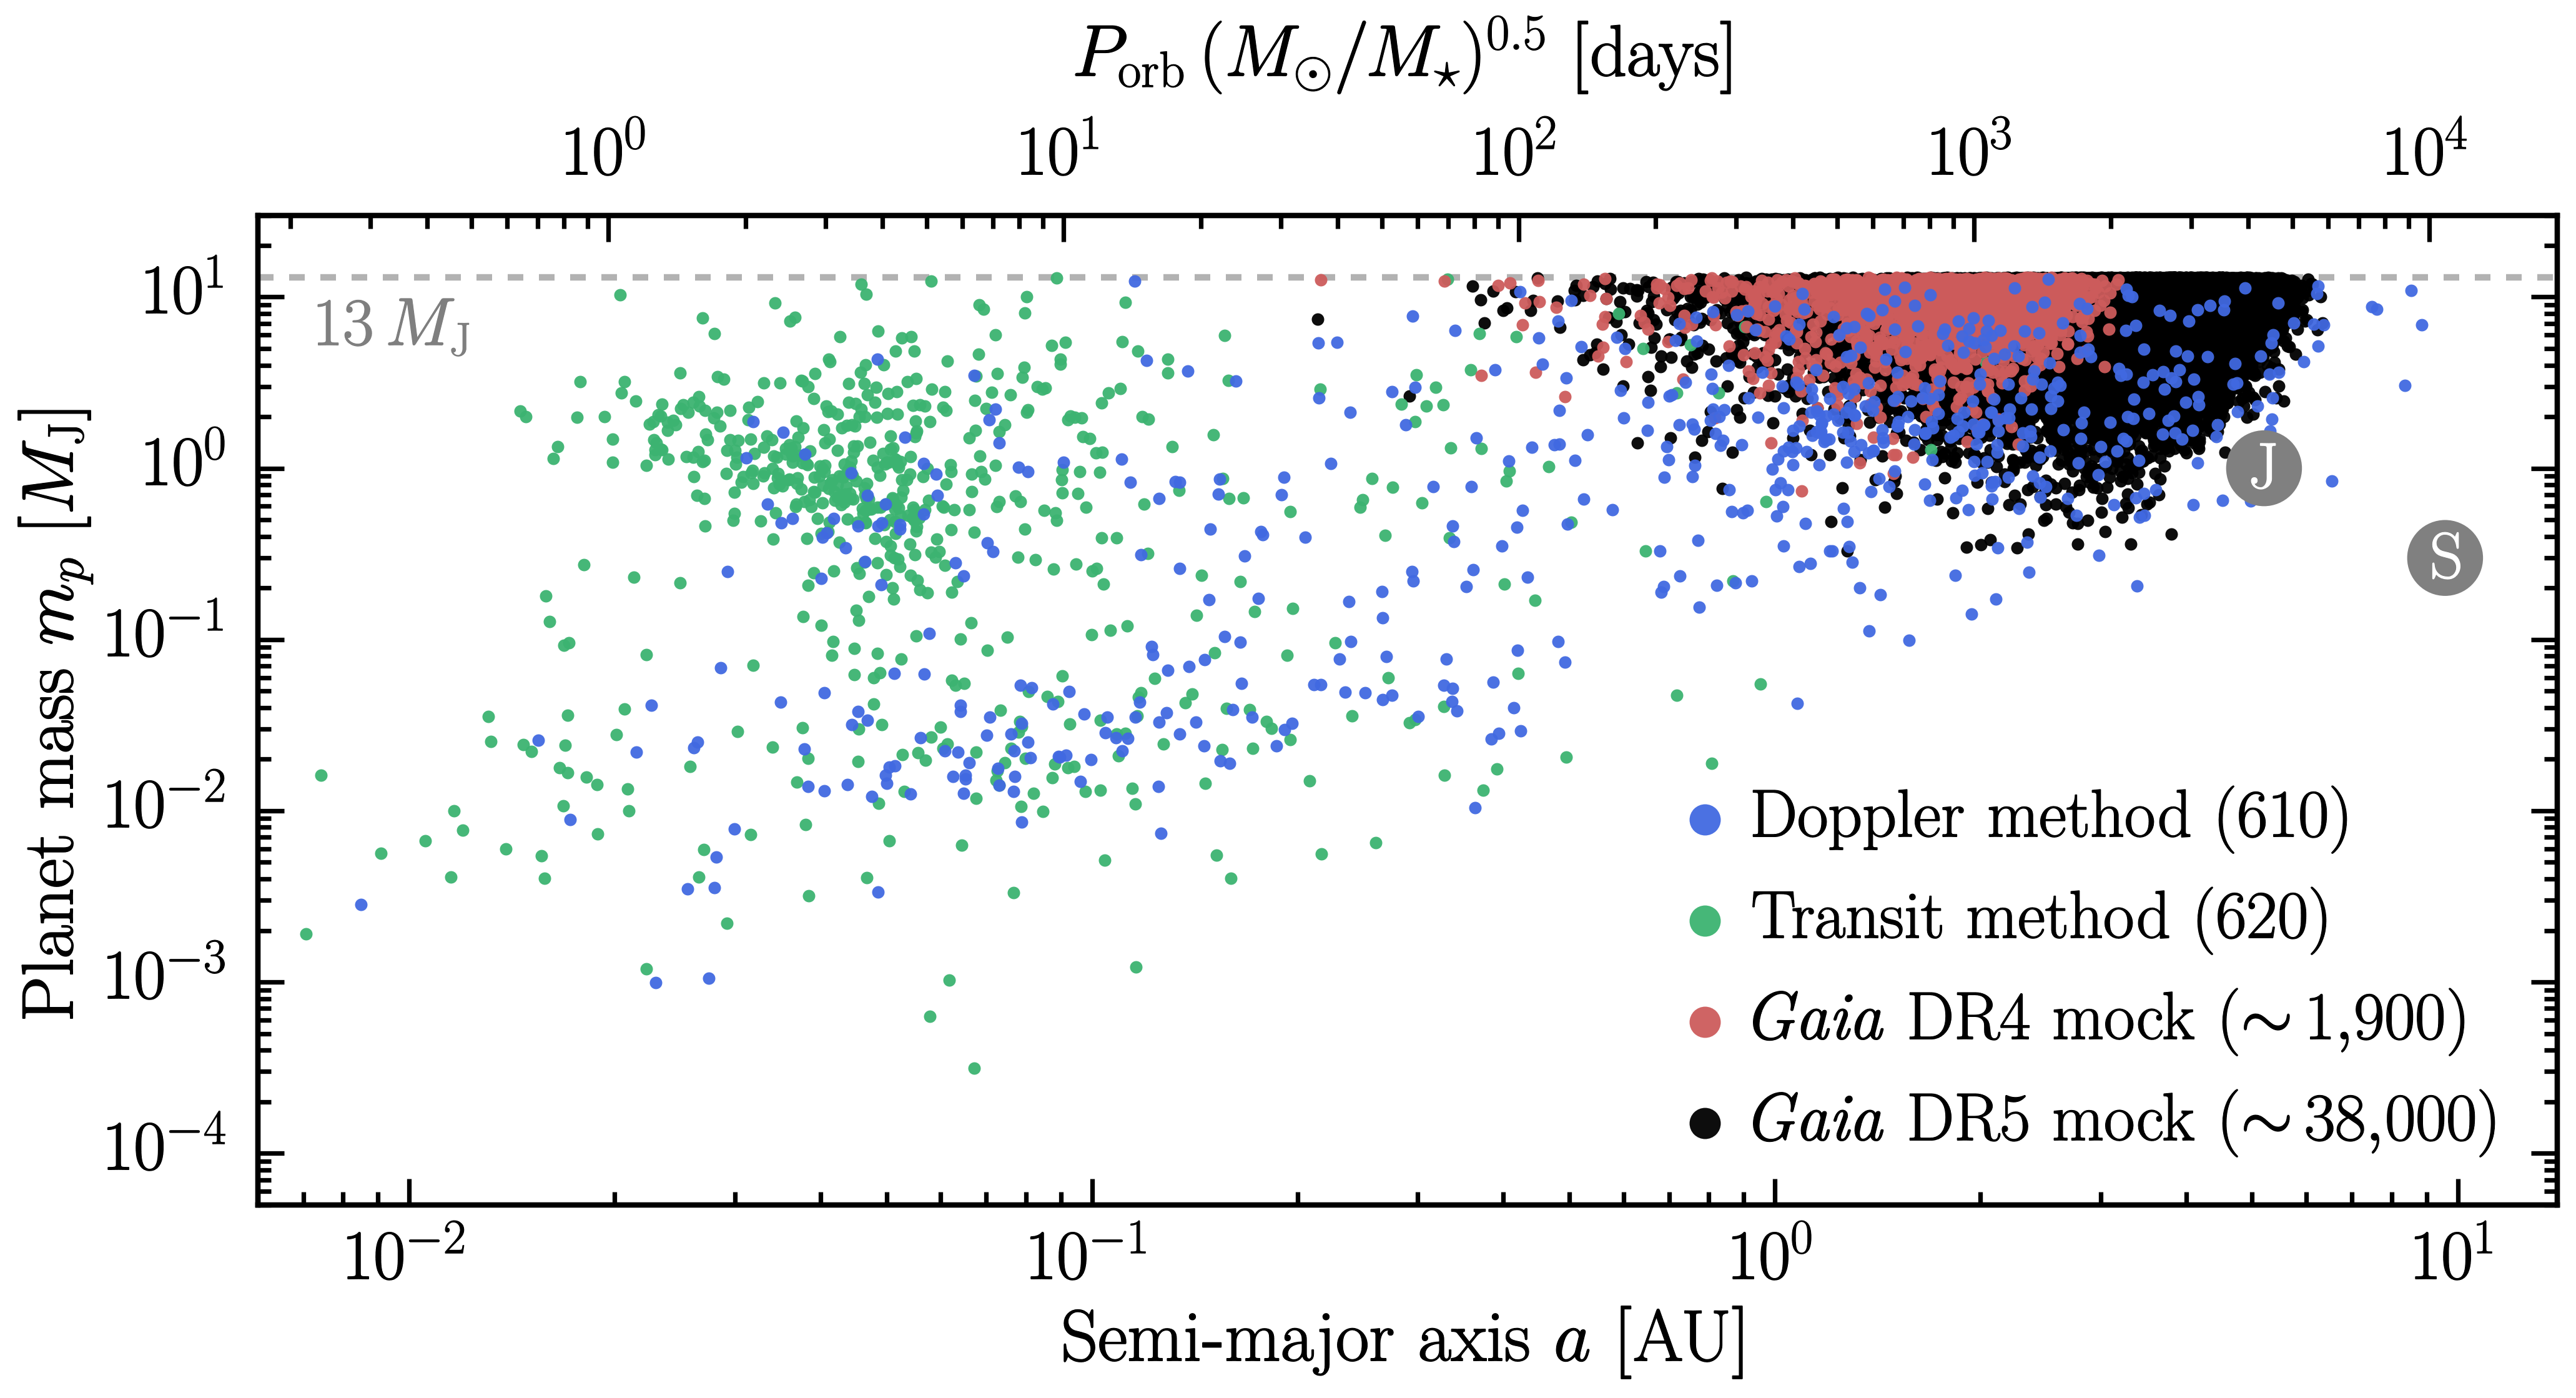

In [26]:
# make plot
fig, ax = plt.subplots(1, 1, figsize=(18.0*0.88, 10.0*0.66), dpi=300, facecolor='white')
ax = np.array([ax, ax.twiny()])
ax[0].axhline(y=13.0, c='k', lw=2.5, ls='--', alpha=0.3, zorder=-10)
ax[0].scatter(semi_as_RV, final_masses_RV, c='royalblue', s=23, linewidth=0.0, alpha=0.95, label=r'$\mathrm{Doppler~method}~(610)$', zorder=10)
ax[0].scatter(semi_as_transit, final_masses_transit, c='mediumseagreen', s=23, linewidth=0.0, alpha=0.95, label=r'$\mathrm{Transit~method}~(620)$')
ax[0].scatter(DR4_masked_semi_as, DR4_masked_planet_masses, c='indianred', s=23, linewidth=0.0, alpha=0.95, label=r'$\mathrm{{\it Gaia}~DR4~mock}~({\sim}\,1{,}900)$')
ax[0].scatter(DR5_masked_semi_as, DR5_masked_planet_masses, c='k', s=23, linewidth=0.0, alpha=0.95, label=r'$\mathrm{{\it Gaia}~DR5~mock}~({\sim}\,38{,}000)$', zorder=-10)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\mathrm{Semi}$-$\mathrm{major~axis}~a~\mathrm{[AU]}$', fontsize=28, labelpad=5)
ax[0].set_ylabel(r'$\mathrm{Planet~mass}~m_p~[M_\mathrm{J}]$', fontsize=28, labelpad=5)
ax[0].set_xlim([0.006, 14.0])
ax[0].set_ylim([0.5e-4, 30.0])
ax[0].legend(loc='lower right', markerscale=2.5, scatterpoints=1, fontsize=26, ncol=1, columnspacing=0.7, handletextpad=0.2, borderaxespad=0.3, handlelength=1.0, frameon=False)
ax[0].text(0.0096, 6.5, r'$13\,M_\mathrm{J}$', horizontalalignment='center', verticalalignment='center', c='k', alpha=0.5, fontsize=26)

# add points and labels for Jupiter and Saturn
ax[0].scatter(5.2038, 1.0, c='grey', s=850, edgecolor='none', zorder=20)
ax[0].scatter(9.5826, 0.299409946, c='grey', s=850, edgecolor='none', zorder=20)
ax[0].text(5.24, 0.94, r'$\mathrm{J}$', horizontalalignment='center', verticalalignment='center', c='white', fontsize=25, zorder=35)
ax[0].text(9.68, 0.28, r'$\mathrm{S}$', horizontalalignment='center', verticalalignment='center', c='white', fontsize=25, zorder=35)

# add period labels to the top x-axis
ax[1].axis([(0.006**1.5)*365.25, (14.0**1.5)*365.25, 0.5e-4, 30.0])
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$P_\mathrm{orb}\,(M_\odot/M_\star)^{0.5}~\mathrm{[days]}$', fontsize=28, labelpad=19)

plt.show()

In [27]:
# there are a lot of Gaia planets on the way!
# however, they will occupy a relatively narrow region of mass-period space